In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


The requirements for verilog module with the video

1. independent of exact formmat
2. must 


In [177]:

video_file = "video.mp4"

In [297]:
TOTAL_LINES = 525
TOTAL_ACTIVE_LINES = 480
TOTAL_PIXELS = 858
TOTAL_ACTIVE_PIXELS = 720
TOTAL_BLANKING_PIXELS = TOTAL_PIXELS - TOTAL_ACTIVE_PIXELS

preamble = [0xFF, 0x00, 0x00]
# https://pub.smpte.org/pub/st293/st0293-2003_stable2010.pdf, table 3
SAV_active = 0b10000000
EAV_active = 0b10011101
SAV_VBI = 0b10101011
EAV_VBI = 0b10110110

EAV_START = 2 * TOTAL_ACTIVE_PIXELS
SAV_START =  2 * TOTAL_PIXELS - 4

DEFAULT_Y = 16
DEFAULT_C = 128
# what is going on during vertical blanking?
# todo do for one frame

In [310]:
# todo clamp values between 1 and 254
cap = cv2.VideoCapture(video_file)
global_frame = np.zeros((TOTAL_ACTIVE_LINES, TOTAL_ACTIVE_PIXELS, 3), np.uint8)

counter = 0
all_frames = []
while (1):
    ret, frame = cap.read()

    if cv2.waitKey(1) & 0xFF == ord('q') or ret == False:
        cap.release()
        cv2.destroyAllWindows()
        break

    frame = cv2.resize(frame, (720, 480), cv2.INTER_AREA)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2YCrCb)
    frame = np.clip(frame, 1, 254)

    lines = np.zeros((TOTAL_LINES, 2 * TOTAL_PIXELS)).astype(np.uint8)
    # YCrCb 4:2:2
    Y = frame[:, :, 0]
    Cr = frame[:, ::2, 1]
    Cb = frame[:, ::2, 2]

    lines[:, 0::2] = DEFAULT_C
    lines[:, 1::2] = DEFAULT_Y
    
    lines[:, EAV_START: EAV_START + 3] = preamble
    lines[:, SAV_START: SAV_START + 3] = preamble

    lines[:TOTAL_ACTIVE_LINES, EAV_START + 3] = EAV_active
    lines[:TOTAL_ACTIVE_LINES, SAV_START + 3] = SAV_active


    lines[TOTAL_ACTIVE_LINES:, EAV_START + 3] = EAV_VBI
    lines[TOTAL_ACTIVE_LINES:, SAV_START + 3] = SAV_VBI

    lines[:TOTAL_ACTIVE_LINES, 0:2 * TOTAL_ACTIVE_PIXELS:4] = Cr
    lines[:TOTAL_ACTIVE_LINES, 1:2 * TOTAL_ACTIVE_PIXELS:2] = Y
    lines[:TOTAL_ACTIVE_LINES, 2:2 * TOTAL_ACTIVE_PIXELS:4] = Cb


    

    x_roll = 4
    lines = np.roll(lines, x_roll)
    lines[0][x_roll-1] = SAV_active
    lines[-1][EAV_START + 4 + x_roll - 1] = EAV_active
    lines = np.roll(lines, TOTAL_LINES - TOTAL_ACTIVE_LINES, 0)
    # lines[TOTAL_LINES - TOTAL_ACTIVE_LINES - 1][2*TOTAL_ACTIVE_PIXELS + 4 - 1] = SAV_active
    lines[0][x_roll-1] = SAV_VBI
    lines[-1][EAV_START + 4 + x_roll - 1] = EAV_VBI



    Cr = lines[:, 0::4]
    Y  = lines[:, 1::2]
    Cb = lines[:, 2::4]

    Cr = np.repeat(Cr, 2, axis=1)
    Cb = np.repeat(Cb, 2, axis=1)
    new_frame = np.zeros((TOTAL_LINES, TOTAL_PIXELS, 3)).astype(np.uint8)
    new_frame[:,:,0] = Y
    new_frame[:,:,1] = Cr
    new_frame[:,:,2] = Cb

    # cv2.imshow('frame', lines)
    # cv2.imshow('frame', cv2.cvtColor(new_frame, cv2.COLOR_YCrCb2BGR))
    # if cv2.waitKey(0) & 0xFF == ord('q'):
    #     cv2.destroyAllWindows()
    #     break
    lines = lines.flatten()
    all_frames.append(lines)


    counter += 1

In [311]:
FRAME_CNT = 60
all_frames = np.array(all_frames[:FRAME_CNT]).flatten()

In [11]:
len(all_frames) / 1000 ** 2

196.3962

dtype('uint8')

In [312]:
with open(f"video_f{FRAME_CNT}.bin", "wb") as fd:
    fd.write(all_frames)

In [223]:
# with open("video.bin", "rb") as fd:
#     all_frames_read =  fd.read()
with open(f"video_f{FRAME_CNT}.bin", "rb") as fd:
    all_frames_read =  fd.read()

In [224]:
all_frames_read = np.array([*all_frames_read])

In [225]:
del all_frames_read
del all_frames

In [198]:
all_frames_read.shape

(54054000,)

In [199]:
all_frames =  np.reshape(all_frames_read, (-1, TOTAL_LINES * 2 * TOTAL_PIXELS)).astype(np.uint8)


In [270]:
try:
    for frame in all_frames:
        frame = np.reshape(frame, (TOTAL_LINES, 2 * TOTAL_PIXELS))
        frame = np.roll(frame, -4)
        frame = np.roll(frame, -(TOTAL_LINES - TOTAL_ACTIVE_LINES), 0)
        frame = frame[:TOTAL_ACTIVE_LINES, :2 * TOTAL_ACTIVE_PIXELS]
        Cr = frame[:TOTAL_ACTIVE_LINES, 0:2 * TOTAL_ACTIVE_PIXELS:4]
        Y  = frame[:TOTAL_ACTIVE_LINES, 1:2 * TOTAL_ACTIVE_PIXELS:2]
        Cb = frame[:TOTAL_ACTIVE_LINES, 2:2 * TOTAL_ACTIVE_PIXELS:4]

        Cr = np.repeat(Cr, 2, axis=1)
        Cb = np.repeat(Cb, 2, axis=1)
        
        new_frame = np.zeros((TOTAL_ACTIVE_LINES, TOTAL_ACTIVE_PIXELS, 3)).astype(np.uint8)
        new_frame[:,:,0] = Y
        new_frame[:,:,1] = Cr
        new_frame[:,:,2] = Cb
        
        frame = cv2.cvtColor(new_frame, cv2.COLOR_YCrCb2BGR)

        # frame = frame[:100, :100]
        # frame = cv2.resize(frame, (480, 480))
        cv2.imshow('frame', frame)
        if cv2.waitKey(33) & 0xFF == ord('q'):
            # cap.release()
            cv2.destroyAllWindows()
            break
finally:
    cv2.destroyAllWindows()
    


ValueError: cannot reshape array of size 1 into shape (525,1716)

In [326]:
def bt656_to_bgr(frame, roll_x = True, roll_y = True):
    frame = np.array(frame)
    if (roll_x):
        frame = np.roll(frame, -4)
    if (roll_y):
        frame = np.roll(frame, -(TOTAL_LINES - TOTAL_ACTIVE_LINES), 0)

    frame = frame[:TOTAL_ACTIVE_LINES, :2 * TOTAL_ACTIVE_PIXELS]
    Cr = frame[:TOTAL_ACTIVE_LINES, 0:2 * TOTAL_ACTIVE_PIXELS:4]
    Y  = frame[:TOTAL_ACTIVE_LINES, 1:2 * TOTAL_ACTIVE_PIXELS:2]
    Cb = frame[:TOTAL_ACTIVE_LINES, 2:2 * TOTAL_ACTIVE_PIXELS:4]
    
    Cr = np.repeat(Cr, 2, axis=1)
    Cb = np.repeat(Cb, 2, axis=1)
    new_frame = np.zeros((TOTAL_ACTIVE_LINES, TOTAL_ACTIVE_PIXELS, 3)).astype(np.uint8)
    new_frame[:,:,0] = Y
    new_frame[:,:,1] = Cr
    new_frame[:,:,2] = Cb
    
    frame = cv2.cvtColor(new_frame, cv2.COLOR_YCrCb2BGR)
    return frame

In [269]:

def decode_and_display_video(video_file_name, decode_bt656 = True, slow_down_coeff = 1, max_frames = None):
    with open(video_file_name, "rb") as fd:
        all_frames_read =  fd.read()
    all_frames_read = np.array([*all_frames_read])
    i_prev1 = 0
    el_prev3 = None
    el_prev2 = None
    el_prev1 = None
    first_sav = None
    last_eav = None
    sav_cnt = 0
    for i, el in enumerate(all_frames_read):
        # print(el_prev3, el_prev2, el_prev1, el)
        if (el_prev3 == preamble[0] 
                and el_prev2 == preamble[1] 
                and el_prev1 == preamble[2] 
                and (el == SAV_active or el == SAV_VBI)):
            first_sav = i
            sav_cnt += 1
            if sav_cnt == 1:
                break
        if (el_prev3 == preamble[0]
                and el_prev2 == preamble[1]
                and el_prev1 == preamble[2]
                and (el == EAV_active)):
            last_eav = i
        el_prev3 = el_prev2
        el_prev2 = el_prev1
        el_prev1 = el
    # print(first_sav,last_eav)
    points_per_frame = TOTAL_LINES * 2 * TOTAL_PIXELS
    all_frames_read = all_frames_read[first_sav - 3:]
    all_frames_read = all_frames_read[:((len(all_frames_read))//points_per_frame)*points_per_frame]
    all_frames =  np.reshape(all_frames_read, (-1, points_per_frame)).astype(np.uint8)
    try:
        if max_frames is None:
            max_frames = len(all_frames)
        
        max_frames = min(max_frames, len(all_frames)) 
        for frame in all_frames[:max_frames]:
            
            frame = np.reshape(frame, (TOTAL_LINES, 2 * TOTAL_PIXELS))

            if decode_bt656:
                frame = bt656_to_bgr(frame)

            # frame = frame[:100, :100]
            # frame = cv2.resize(frame, (480, 480))
            cv2.imshow('frame', frame)
            if cv2.waitKey(int(33/slow_down_coeff)) & 0xFF == ord('q'):
                # cap.release()
                cv2.destroyAllWindows()
                return frame
    except Exception as e:
        print(e)
    finally:
        cv2.destroyAllWindows()
        return frame
        

In [ ]:
%%sql


In [343]:
frame = decode_and_display_video("../../../../../../FPGA/tb/video_f60_scrambled.bin", decode_bt656=True, slow_down_coeff=0.1)

In [313]:
frame_normal = decode_and_display_video("video_f60.bin", decode_bt656=True, slow_down_coeff=0.1, max_frames = 10)

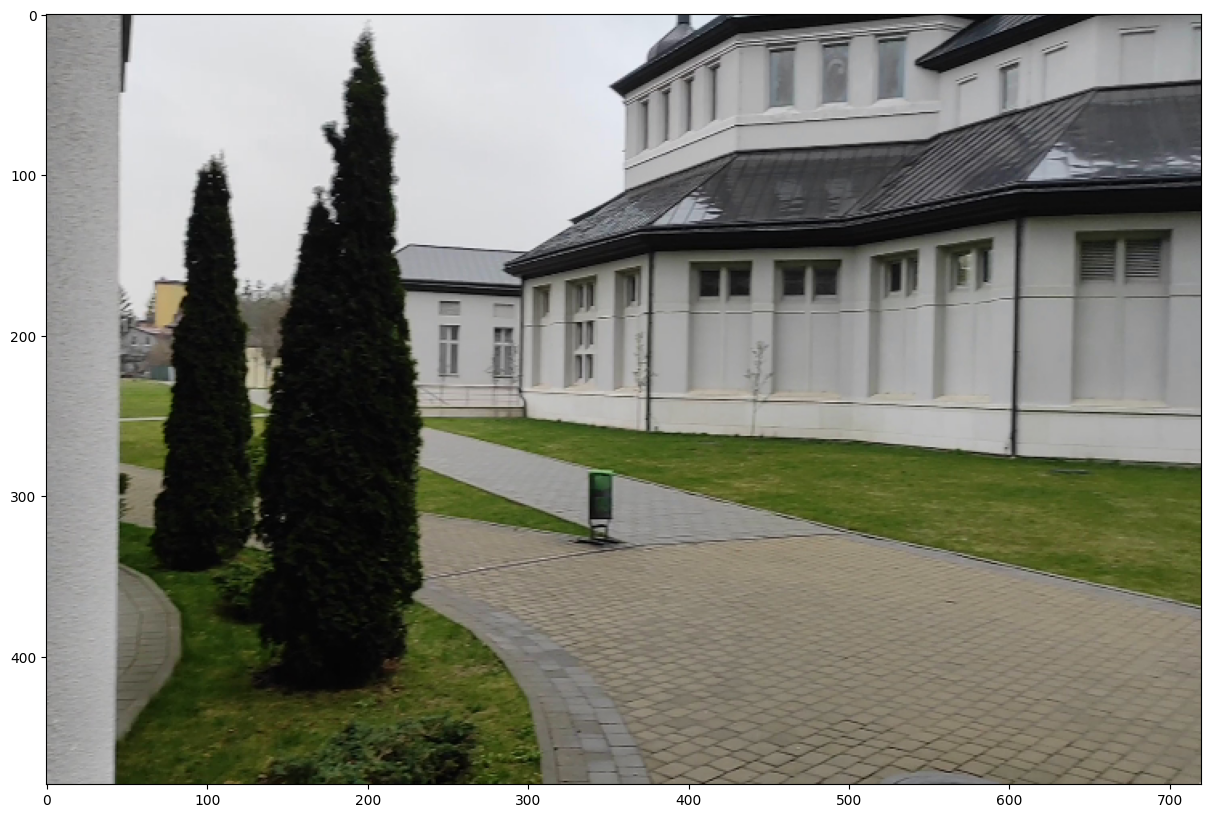

In [267]:
plt.figure(figsize=(20, 10))
plt.imshow(frame_normal if len(frame_normal.shape) == 2 else cv2.cvtColor(frame_normal, cv2.COLOR_BGR2RGB), cmap= "gray" if len(frame_normal.shape) == 2 else None)

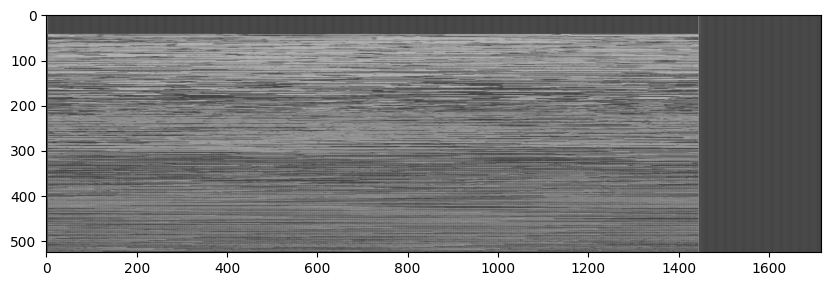

In [320]:
plt.figure(figsize=(10, 10))
plt.imshow(frame if len(frame.shape) == 2 else cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), cmap= "gray" if len(frame.shape) == 2 else None)

In [344]:
frame_decrypted = decode_and_display_video("../../../../../../FPGA/tb/video_f60_descrambled.bin", decode_bt656=True, slow_down_coeff=0.1)

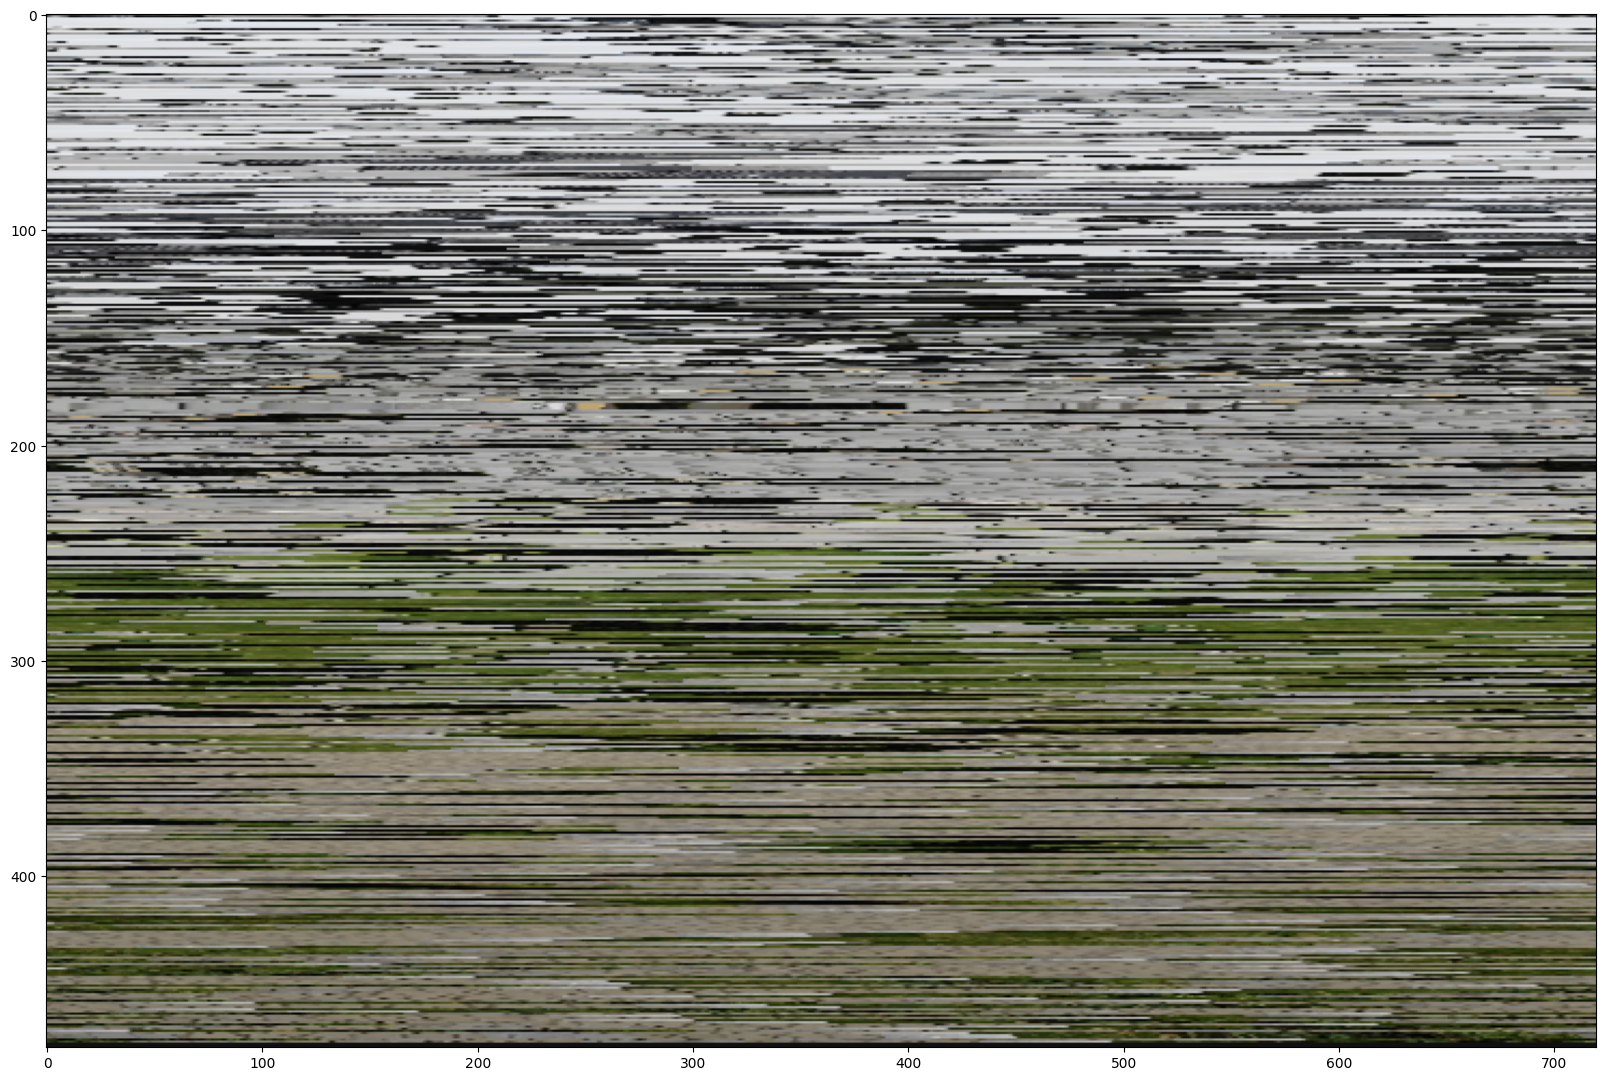

In [340]:
plt.figure(figsize=(20, 20))
plt.imshow(frame_decrypted if len(frame_decrypted.shape) == 2 else cv2.cvtColor(frame_decrypted, cv2.COLOR_BGR2RGB), cmap= "gray" if len(frame.shape) == 2 else None)

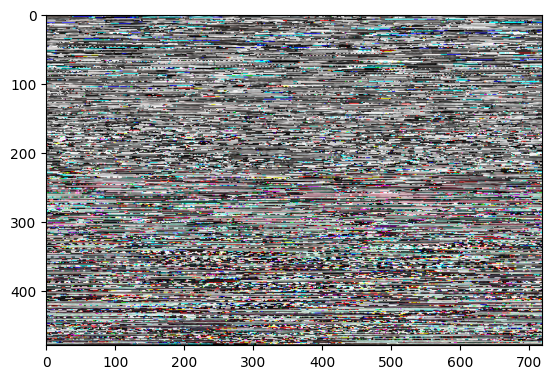

In [339]:
plt.imshow(frame_decrypted - frame)

5.477225575051661

## Attempt at breaking the scrambler

In [323]:
# O(m * n ^ 2) or 360 times slower frame processing
reference_line = frame[TOTAL_LINES - TOTAL_ACTIVE_LINES][4:2*TOTAL_ACTIVE_PIXELS + 4]
unrolled_frame = [reference_line] 
for i in range(TOTAL_LINES - TOTAL_ACTIVE_LINES + 1, len(frame)):
    line = frame[i][4:2*TOTAL_ACTIVE_PIXELS + 4]
    rolled_line = line 
    distances = []
    for j in range(0, len(line), 4):
        # distances.append(np.linalg.norm(reference_line - rolled_line))
        distances.append(np.sum(np.abs(reference_line - rolled_line)))
        rolled_line = np.roll(rolled_line, 4, axis=0)
    optimal_roll = np.argmin(distances)
    reference_line = np.roll(line, optimal_roll * 4, axis=0)
    unrolled_frame.append(reference_line)


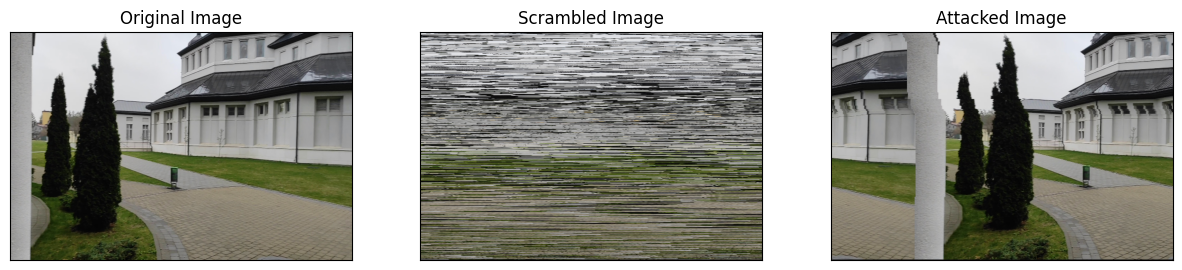

In [328]:

plt.figure(figsize=(15,5))
plt.subplot(131),plt.imshow(cv2.cvtColor(frame_normal, cv2.COLOR_BGR2RGB),cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(cv2.cvtColor(bt656_to_bgr(frame), cv2.COLOR_BGR2RGB),cmap = 'gray')
plt.title('Scrambled Image'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(cv2.cvtColor(bt656_to_bgr(unrolled_frame, roll_x=False, roll_y=False), cv2.COLOR_BGR2RGB),cmap = 'gray')
plt.title('Attacked Image'), plt.xticks([]), plt.yticks([])
plt.show()

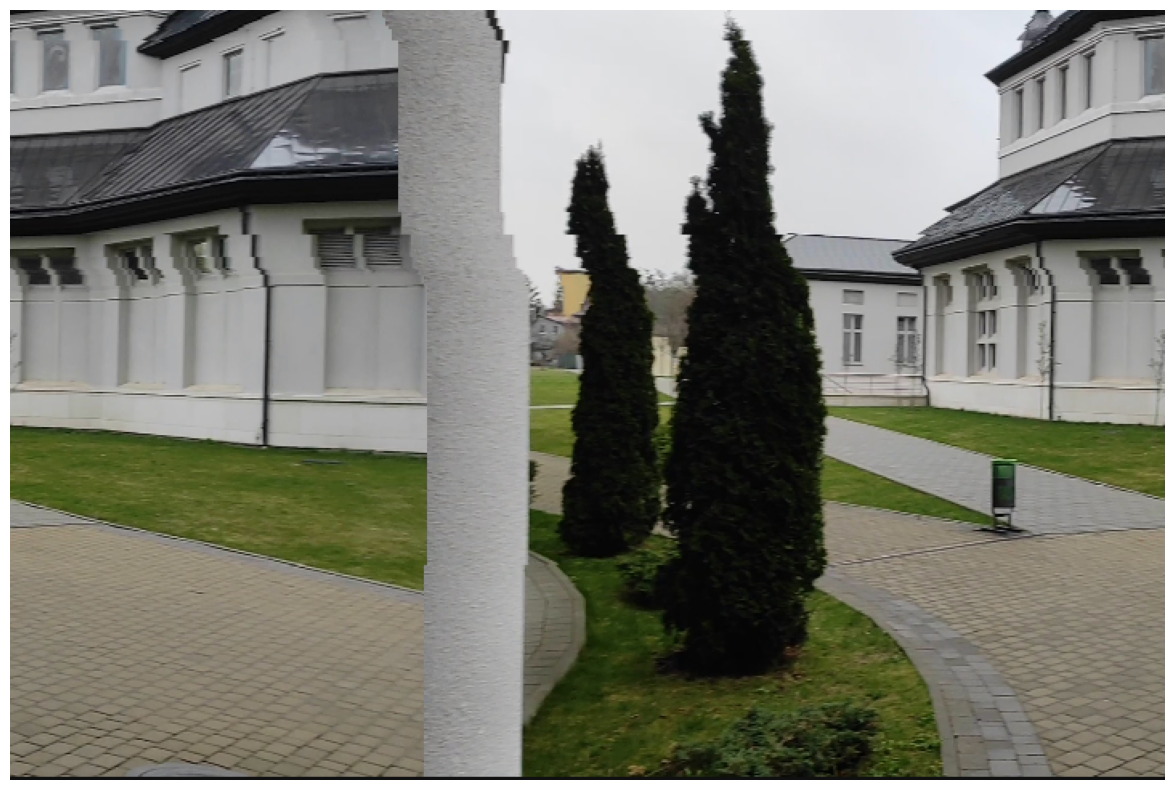

In [165]:
plt.figure(figsize=(20,10))
plt.axis("off")
plt.imshow(cv2.cvtColor(bt656_to_bgr(unrolled_frame, roll_x=False), cv2.COLOR_BGR2RGB), cmap="gray")

In [121]:
rolled_line

array([[16, 16, 16],
       [16, 16, 16],
       [16, 16, 16],
       ...,
       [16, 16, 16],
       [16, 16, 16],
       [16, 16, 16]], dtype=uint8)

In [ ]:
plt.figure(figsize=(20, 10))
plt.imshow(frame, cmap="gray")

In [35]:
new_frame.shape

(480, 720, 3)

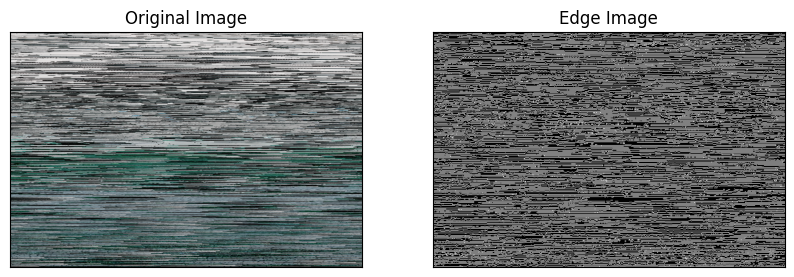

In [25]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img = frame
assert img is not None, "file could not be read, check with os.path.exists()"
edges = cv.Canny(img,100,200)
plt.figure(figsize=(10,5))
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

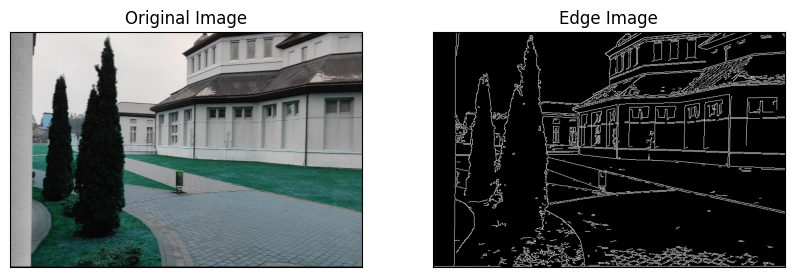

In [39]:
img = frame_normal
assert img is not None, "file could not be read, check with os.path.exists()"
edges = cv.Canny(img,100,200)
plt.figure(figsize=(10,5))
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [53]:
cv2.getGaussianKernel(5, 1).T[0]

array([0.05448868, 0.24420134, 0.40261995, 0.24420134, 0.05448868])

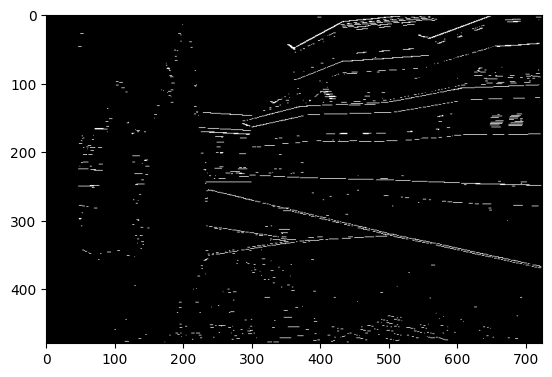

In [74]:
kernel = cv2.getGaussianKernel(5, 5).T[0]
img = np.diff([np.convolve(i, kernel) for i in cv2.cvtColor(frame_normal, cv2.COLOR_BGR2GRAY)], axis=0)
img[img < 30] = 0
img[img >= 30] = 255
plt.imshow(img, cmap="gray")

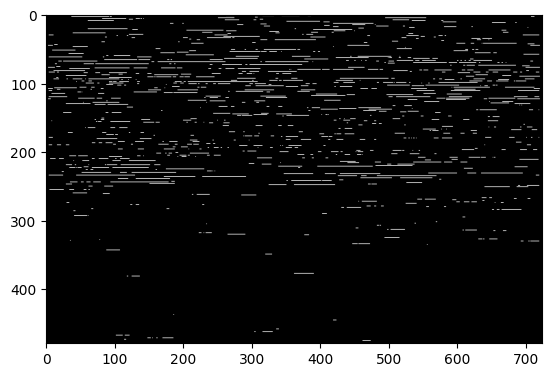

In [83]:
kernel = cv2.getGaussianKernel(5, 5).T[0]
img = np.diff([np.convolve(i, kernel) for i in cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)], axis=0)
thresh = 150
img[img < thresh] = 0
img[img >= thresh] = 255
plt.imshow(img, cmap="gray")

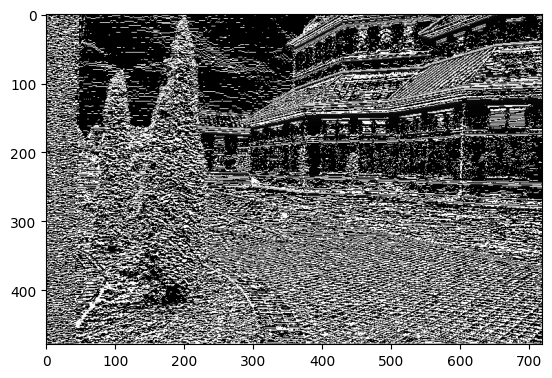

In [41]:
plt.imshow(np.diff(cv2.cvtColor(frame_normal, cv2.COLOR_BGR2GRAY), axis=0), cmap="gray")

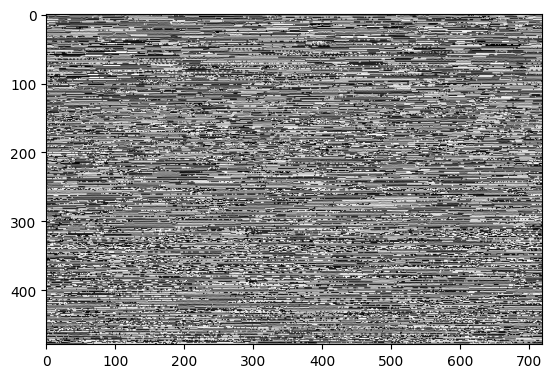

In [40]:
plt.imshow(np.diff(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), axis=0), cmap="gray")